In [8]:
#In this file, I will add the features of the surrounding points into each point. 
#meaning, a point in the middle would have its own air temp, plus the 9 surrounding air temperatures
#i will repeat that for each feature, except the x and y coordinates. 
#Hopefully, this will increase our ability to predict velocity. 

#I will leave the data as its original square with the fill values, and add the new columns. I will then select
#for just the ice sheet/areas where there is velocity by removing rows where ice_velocity = NaN

#IMPORTANT NOTE: I have created a slightly complicated naming system for neighbouring cells' features. 
#they are numbered 1-8 around the current cell, with 1 being the top left hand corner and counting clockwise


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_error

df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

df.head() 

precip_df = df[['x-axis', 'y-axis', 'precipitation']].copy()
air_temp_df = df[['x-axis', 'y-axis', 'air_temp']].copy()
ocean_temp_df = df[['x-axis', 'y-axis', 'ocean_temp']].copy()


In [9]:
import pandas as pd
import numpy as np


def add_neighbor_features(df, feature_col, prefix):
    # Create a dictionary for faster lookup
    lookup = {(x, y): df.loc[i, feature_col] for i, (x, y) in enumerate(zip(df['x-axis'], df['y-axis']))}
    k = 121600  # Scale factor
    relative_positions = [(-1*k, 1*k), (0*k, 1*k), (1*k, 1*k), (1*k, 0*k), (1*k, -1*k), 
                          (0*k, -1*k), (-1*k, -1*k), (-1*k, 0*k)]

    # New DataFrame for results
    new_df = df.copy()

    # Iterate over rows
    for index, row in df.iterrows():
        x, y = row['x-axis'], row['y-axis']
        for i, (dx, dy) in enumerate(relative_positions, 1):
            nx, ny = x + dx, y + dy
            neighbor_feature = lookup.get((nx, ny), np.nan)
            new_df.loc[index, f'{prefix}_{i}'] = neighbor_feature

    return new_df



In [10]:
#getting neighbour columns 
precip_neighbours = add_neighbor_features(precip_df, 'precipitation', 'precip')
air_temp_neighbours = add_neighbor_features(air_temp_df, 'air_temp', 'air_temp')
ocean_temp_neighbours = add_neighbor_features(ocean_temp_df, 'ocean_temp', 'ocean_temp')

#joining all the tables into one mega table 
precip_neighbours = precip_neighbours.drop(columns = ['x-axis','y-axis'])
air_temp_neighbours = air_temp_neighbours.drop(columns = ['x-axis','y-axis'])
ocean_temp_neighbours = ocean_temp_neighbours.drop(columns = ['x-axis','y-axis'])

concat_df = df[['x-axis', 'y-axis', 'ice_velocity']].copy()

result_df = pd.concat([concat_df, precip_neighbours, air_temp_neighbours, ocean_temp_neighbours], axis=1)
result_df.head()

#reshuffle final df so target is last column

result_df = result_df[['x-axis','y-axis','precipitation', 'precip_1', 'precip_2', 'precip_3', 'precip_4', 
                      'precip_5', 'precip_6', 'precip_7', 'precip_8', 'air_temp', 'air_temp_1', 'air_temp_2', 
                      'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7', 'air_temp_8', 
                      'ocean_temp', 'ocean_temp_1', 'ocean_temp_2', 'ocean_temp_3', 'ocean_temp_4', 
                      'ocean_temp_5', 'ocean_temp_6', 'ocean_temp_7', 'ocean_temp_8', 'ice_velocity']]


result_df.dropna(subset=["ice_velocity"], inplace=True)
 
result_df.head()


,x-axis,y-axis,precipitation,precip_1,precip_2,precip_3,precip_4,precip_5,precip_6,precip_7,...,ocean_temp,ocean_temp_1,ocean_temp_2,ocean_temp_3,ocean_temp_4,ocean_temp_5,ocean_temp_6,ocean_temp_7,ocean_temp_8,ice_velocity
431,-243200,2067200,404.280640,396.511230,434.959656,436.197693,527.547485,461.252808,228.084351,186.801819,...,272.344940,272.423370,272.451752,272.460266,272.534760,272.646973,272.485016,272.184448,272.384827,4.782738
432,-121600,2067200,527.547485,434.959656,436.197693,403.362183,352.272278,247.852112,461.252808,228.084351,...,272.534760,272.451752,272.460266,272.468903,272.597290,272.825623,272.646973,272.485016,272.344940,0.017201
433,0,2067200,352.272278,436.197693,403.362183,437.285950,261.181396,137.003937,247.852112,461.252808,...,272.597290,272.460266,272.468903,272.928741,273.296387,273.108215,272.825623,272.646973,272.534760,590.315247
434,121600,2067200,261.181396,403.362183,437.285950,388.587189,358.309296,208.756500,137.003937,247.852112,...,273.296387,272.468903,272.928741,273.101837,273.666199,273.338440,273.108215,272.825623,272.597290,45.191998
435,243200,2067200,358.309296,437.285950,388.587189,372.779785,101.287170,24.054939,208.756500,137.003937,...,273.666199,272.928741,273.101837,272.887238,273.610138,273.437042,273.338440,273.108215,273.296387,17.135721


In [11]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState)
        
        model.fit(X_train, y_train)
        
        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

In [12]:
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target (for ice mask)
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df


def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)

In [13]:
seed = 101
result_df_scaled = scale(result_df)
IV_importances, IV_std_importances = doRandomForest(result_df_scaled, seed, 30, 'ice_velocity', result_df)


Training Average Score: 0.8731, Std Dev: 0.0162
Training Average RMSE: 108.16, Std Dev: 9.29


Test Average Score: 0.0697, Std Dev: 0.2069
Test Average RMSE: 285.30, Std Dev: 41.96


Average Importances: [0.01113265 0.02172083 0.04933474 0.03092435 0.03191351 0.01365272
 0.10478029 0.02490995 0.03042098 0.02284384 0.02162971 0.112315
 0.01282879 0.02040791 0.0180971  0.07074429 0.08846769 0.05324319
 0.01478224 0.01501873 0.01999319 0.04314465 0.01312849 0.01275241
 0.02658204 0.03186029 0.04403082 0.02126242 0.01807719]
Importances Std Dev: [0.0035826  0.01359957 0.02717266 0.01300638 0.01671924 0.00478298
 0.05394346 0.01298115 0.01345028 0.00773119 0.00996795 0.03799013
 0.00405901 0.00992342 0.00669225 0.03538001 0.0397932  0.0371976
 0.0041739  0.0060598  0.00711656 0.02300258 0.0033098  0.00369623
 0.01315727 0.01947049 0.0196674  0.00796887 0.00924772]


 Train-Test (Difference): 0.8034


In [31]:
#visualising these importance results to get an idea of how the new features are aiding the prediction

def plot_importance(importance_df, std_dev, title):
    for column in importance_df.columns: 
            importance_df[column] = importance_df[column].abs()
            
    transposed_importance_df = importance_df.T
    transposed_importance_df.reset_index(inplace=True)
    transposed_importance_df.columns = ['Feature', 'Importance']
    
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], color='skyblue')
    
    #Error bars 
    plt.errorbar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], yerr=std_dev, fmt='o', color='black', capsize=5)
        
    plt.xlabel('Features')
    plt.ylabel('Importance Value')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

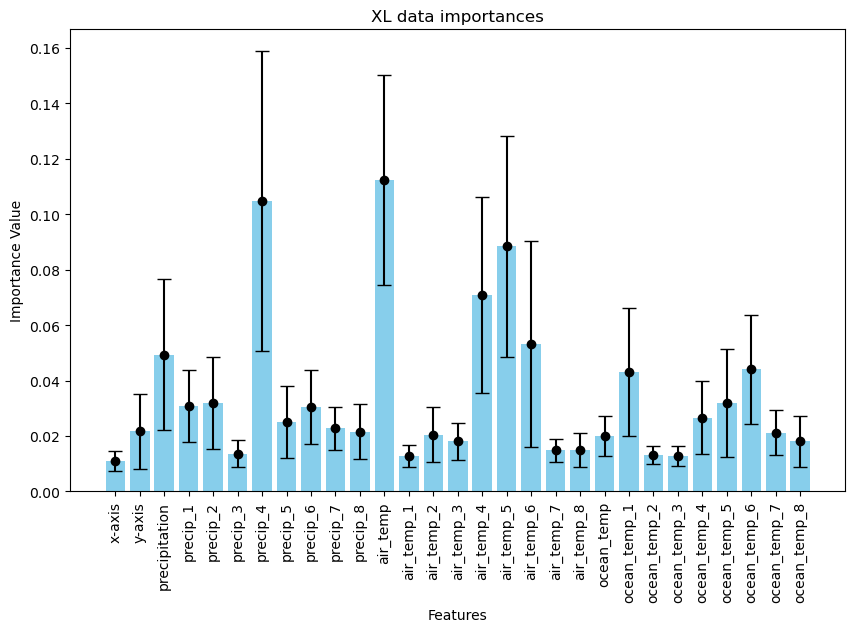

In [32]:
cols = ['x-axis','y-axis','precipitation', 'precip_1', 'precip_2', 'precip_3', 'precip_4', 
                      'precip_5', 'precip_6', 'precip_7', 'precip_8', 'air_temp', 'air_temp_1', 'air_temp_2', 
                      'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7', 'air_temp_8', 
                      'ocean_temp', 'ocean_temp_1', 'ocean_temp_2', 'ocean_temp_3', 'ocean_temp_4', 
                      'ocean_temp_5', 'ocean_temp_6', 'ocean_temp_7', 'ocean_temp_8']

importances_IV_df = pd.DataFrame([IV_importances], columns=cols)

importances_IV_df.head()


plot_importance(importances_IV_df, IV_std_importances, "XL data importances")


In [97]:
#doing a grid search of best hyperparameters - note, not doing it in the same way as I have before where I do the
#grid search 30 times and find the best params, as the RF with this many columns takes significantly longer

from sklearn.model_selection import GridSearchCV

result_df_scaled = scale(result_df)


X = result_df_scaled.iloc[:, :-1]
y = result_df_scaled.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': [3, 6, 9, 12, 15, 18, 21, 24, 27],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],   # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10, 15, 20],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 10],     # Minimum number of samples required at each leaf node
    'max_leaf_nodes':[60, 90, 120, 200]
}

# Create a base model
rf = RandomForestRegressor(random_state = seed)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Test the best model
best_rf = grid_search.best_estimator_
test_score = best_rf.score(X_test, y_test)
print("Test Score: ", test_score)


Fitting 3 folds for each of 10800 candidates, totalling 32400 fits
Best parameters found:  {'max_depth': 30, 'max_features': 6, 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Score:  0.18830566830227813


In [53]:
#after this tuning, I will now plot importances with the tuned model

#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doTunedRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, max_depth = 30, max_features = 6, 
                                     max_leaf_nodes = 200, min_samples_leaf = 1, min_samples_split = 2, 
                                      n_estimators = 200)
        
        model.fit(X_train, y_train)
        
        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances


In [54]:
seed = 101
result_df_scaled = scale(result_df)
IV_importances_tuned, IV_std_importances_tuned = doTunedRandomForest(result_df_scaled, seed, 30, 'ice_velocity', result_df)


Training Average Score: 0.8845, Std Dev: 0.0112
Training Average RMSE: 103.30, Std Dev: 8.50


Test Average Score: 0.1279, Std Dev: 0.1698
Test Average RMSE: 277.30, Std Dev: 42.72


Average Importances: [0.01555194 0.02200658 0.05543903 0.02778922 0.03218154 0.0184677
 0.06279104 0.03191211 0.03669587 0.02234963 0.02839482 0.07906563
 0.02127882 0.02791339 0.02797306 0.06766659 0.06906945 0.05806125
 0.02486749 0.02453625 0.02897747 0.03321833 0.02054377 0.01815642
 0.02900373 0.02994609 0.03233786 0.03030472 0.02350019]
Importances Std Dev: [0.00346075 0.00714015 0.01435531 0.00774849 0.00956684 0.00313064
 0.02102694 0.00995443 0.00770966 0.00530019 0.00753463 0.01329814
 0.00487322 0.00693821 0.00637814 0.01541697 0.01532758 0.01437042
 0.00390671 0.00421796 0.00436308 0.01133549 0.0040197  0.00307621
 0.00737878 0.00722682 0.00667162 0.00561729 0.00556899]


 Train-Test (Difference): 0.7567


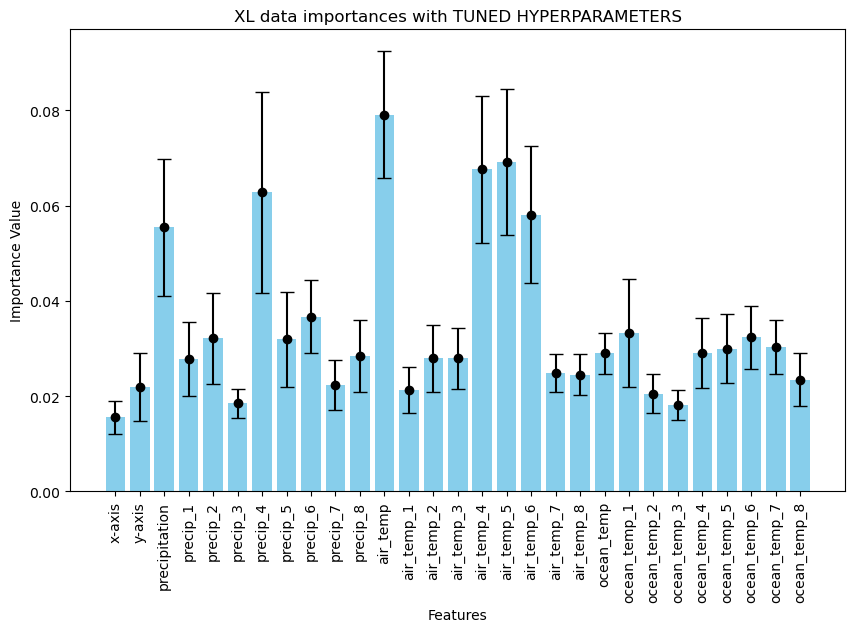

In [37]:
cols = ['x-axis','y-axis','precipitation', 'precip_1', 'precip_2', 'precip_3', 'precip_4', 
                      'precip_5', 'precip_6', 'precip_7', 'precip_8', 'air_temp', 'air_temp_1', 'air_temp_2', 
                      'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7', 'air_temp_8', 
                      'ocean_temp', 'ocean_temp_1', 'ocean_temp_2', 'ocean_temp_3', 'ocean_temp_4', 
                      'ocean_temp_5', 'ocean_temp_6', 'ocean_temp_7', 'ocean_temp_8']

importances_IV_df_tuned = pd.DataFrame([IV_importances_tuned], columns=cols)

importances_IV_df_tuned.head()


plot_importance(importances_IV_df_tuned, IV_std_importances_tuned, "XL data importances with TUNED HYPERPARAMETERS")


In [49]:
# after this, try a bunch of different models on the XL dataset - see if RF is still the most promising
#also try adding in the features that I engineered on top of the XL dataset to see if that can make any difference


#+++++++++++++++++++++++++++++++++++++++++++++ LINEAR REGRESSION +++++++++++++++++++++++++++++++++++++++++++

import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def doLinReg(preprocessed_df, seed, n_runs):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    coefficients = []

    for i in range(n_runs):
        randomState = i*seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = LinearRegression()
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        coefficients.append(model.coef_)
        y_test_predicted = model.predict(X_test)
        test_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_coefficients, std_coefficients = np.mean(coefficients, axis=0), np.std(coefficients, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Coefficients:", avg_coefficients)
    print("Coefficients Std Dev:", std_coefficients)

    return avg_coefficients, std_coefficients



In [52]:
##+++++++++++++++++++++++++++++++++++++++++++++ ICE VELOCITY ++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(result_df)

result_df.head()

average_coef_IV = doLinReg(scaled_df, seed, 50)



Training Average Score: 0.2689, Std Dev: 0.0276
Training Average RMSE: 0.07, Std Dev: 0.01


Test Average Score: -0.0138, Std Dev: 0.1552
Test Average RMSE: 0.08, Std Dev: 0.01


Average Coefficients: [ 0.02324682  0.00355163  0.19890208 -0.106385    0.02721503 -0.13027681
  0.22068143 -0.06870295  0.05983104  0.01951985  0.00416532  0.49457118
 -0.07843163 -0.07075888  0.10066486 -0.20912508 -0.04772381 -0.00563205
 -0.15280519 -0.00785787  0.05500331  0.03853537 -0.01705365  0.03265099
 -0.1480735  -0.02591961  0.17165319 -0.17500763  0.02030808]
Coefficients Std Dev: [0.01775233 0.01195557 0.15964198 0.13911189 0.09525317 0.06558853
 0.08764988 0.05248955 0.1170047  0.06476419 0.09110691 0.10776128
 0.0736595  0.08718954 0.0714653  0.09420296 0.06663721 0.10393911
 0.08461947 0.09535902 0.11080727 0.03668058 0.06686897 0.06555653
 0.08001846 0.05138597 0.0732722  0.06467776 0.05919348]
